In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hcipy import *
from hcipy.mode_basis.zernike import make_zernike_basis
from hcipy.atmosphere import *
from imageio import get_writer
from tqdm import tqdm

In [145]:

def get_star_power(luminosity, distance_to_star=600, relative_magnitude=0.5):
    permitivity = 8.854187817e-12 #F/m
    c = 299792458 #m/s
    diameter_t = 152 #mm
    sun_luminosity = 3.828e26 #W
    distance = distance_to_star * 9.461e15 #m
    star_luminosity = sun_luminosity * luminosity #W
    star_flux_density = star_luminosity/(4*np.pi*distance**2) #W/m^2
    area = np.pi*(diameter_t/2)**2 #m^2
    electric_field = np.sqrt(star_flux_density*(2/(permitivity*c))) 
    el_power_at_pupil = electric_field**2 * area 

    janskys = 1e-26 #W/(m^2 Hz) 
    flux_m0_V = 3640 # Janskys at V band - 550nm 
    delta_m = relative_magnitude
    scale = 2.512**delta_m
    flux_m = flux_m0_V * scale
    flux_m = flux_m * janskys #W/m^2
    electric_field_m = np.sqrt(flux_m*(2/(permitivity*c))) 
    el_power_at_pupil_m = electric_field_m**2 * area
    print(el_power_at_pupil_m)
    return el_power_at_pupil, el_power_at_pupil_m


N = 801 #Resolution of the grid.
d = 0.6 #Diameter of the aperture.
wavelength = 590e-9 # meters. Wavelength of the light.
luminosity = 87100 #W/m^2. Intensity of the light times the luminosity of the sun
distance_to_star = 600 #ly
coeficients_flat = [0, 0, 0, 0, 0, 0, 0, 0] #flat wavefront.
#coeficients = [0, 295e-9, 0, 0, 0, 0, 0, 0] #tilted wavefront.
coeficients = [0, 0, 0, 3200e-9, 2000e-9, 1200e-9, 600e-9, 300e-9]

#Defining the grids.
pupil_grid = make_pupil_grid(N)
aperture = make_circular_aperture(d)(pupil_grid)

#The wavefront in the pupil.
zern = make_zernike_basis(8, d, pupil_grid, starting_mode=1, ansi=False, radial_cutoff=True, use_cache=True)
full_wf = zern.linear_combination(coeficients)
pupil_wavefront = Wavefront(np.exp(1j*((2*np.pi)/590e-9)*full_wf)*aperture, wavelength=590e-9)

zern_flat = make_zernike_basis(8, d, pupil_grid, starting_mode=1, ansi=False, radial_cutoff=True, use_cache=True)
full_wf_flat = zern_flat.linear_combination(coeficients_flat)
pupil_wavefront_flat = Wavefront(np.exp(1j*((2*np.pi)/590e-9)*full_wf_flat)*aperture, wavelength=590e-9)


pupil_wavefront.total_power = 1e-13
pupil_wavefront_flat.total_power = get_star_power(luminosity, distance_to_star=distance_to_star)
print(pupil_wavefront_flat.total_power)


1.1257481819350057


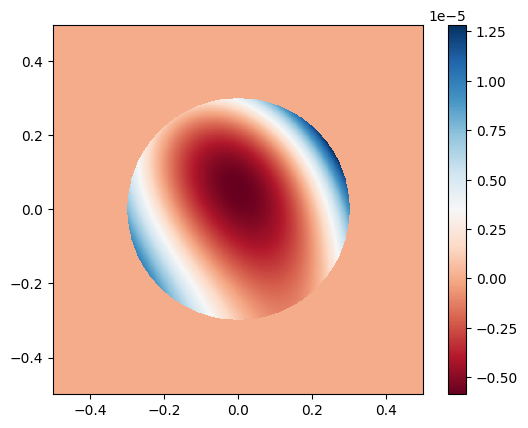

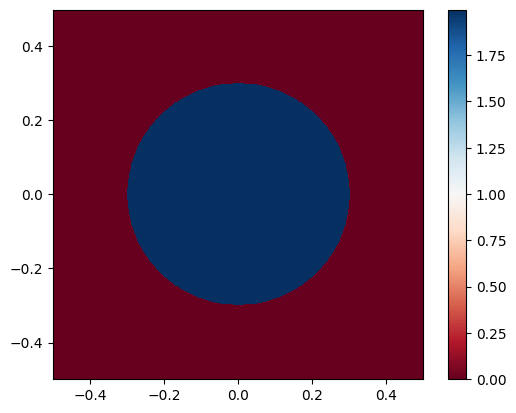

In [130]:

# imshow_field(aperture, cmap='RdBu')
# plt.colorbar()
# plt.show()

imshow_field(full_wf, cmap='RdBu')
plt.colorbar()
plt.show()

imshow_field(pupil_wavefront_flat.amplitude, cmap='RdBu')
plt.colorbar()
plt.show()


1.09137918974839


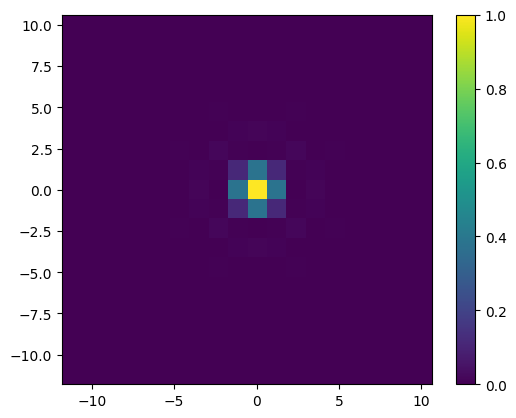

In [131]:
#focal_grid = make_focal_grid(q=1, num_airy=10, spatial_resolution=1)
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, num_airy=10)
focal_grid = focal_grid.scaled(wavelength)
#Aperture function

#The propagator.
prop = FraunhoferPropagator(aperture.grid, focal_grid, focal_length=1)
#Now we propagate it to the focal plane.
focal_wavefront = prop.forward(pupil_wavefront_flat)
print(focal_wavefront.total_power)
#imshow_field(np.log10(focal_wavefront.intensity/focal_wavefront.intensity.max()), vmin=-1)
imshow_field(focal_wavefront.intensity/focal_wavefront.intensity.max(), vmin=0, grid_units=0.5e-6)
plt.colorbar()
plt.show()
# imshow_field(focal_wavefront.amplitude, vmin=0, grid_units=0.5e-6)
# plt.colorbar()
# plt.show()


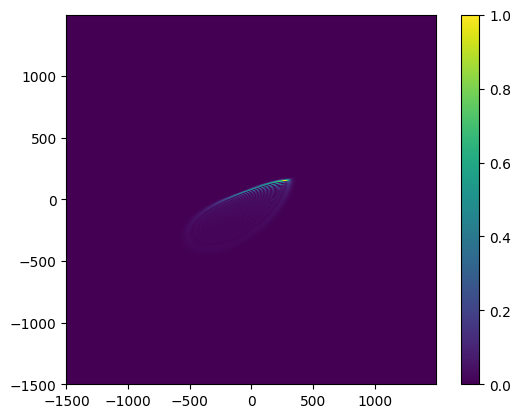

In [151]:
focal_grid = make_focal_grid(q=1, num_airy=1500, spatial_resolution=1)
#focal_grid = make_focal_grid
# _from_pupil_grid(pupil_grid, q=1)
#Aperture function

#The propagator.
prop = FraunhoferPropagator(aperture.grid, focal_grid, focal_length=2)
#Now we propagate it to the focal plane.
focal_wavefront = prop.forward(pupil_wavefront)

imshow_field(focal_wavefront.intensity/focal_wavefront.intensity.max(), vmin=0)
#imshow_field(focal_wavefront.intensity/focal_wavefront.intensity.max())
plt.colorbar()
plt.show()


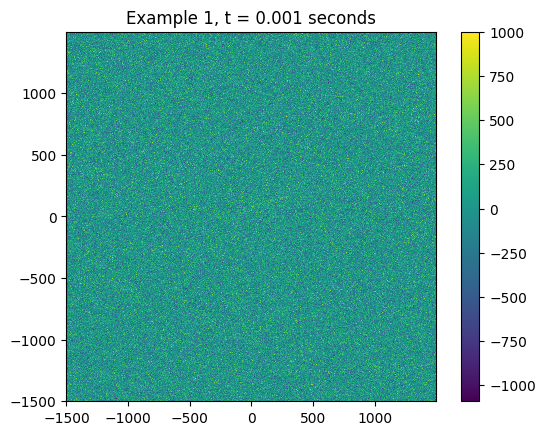

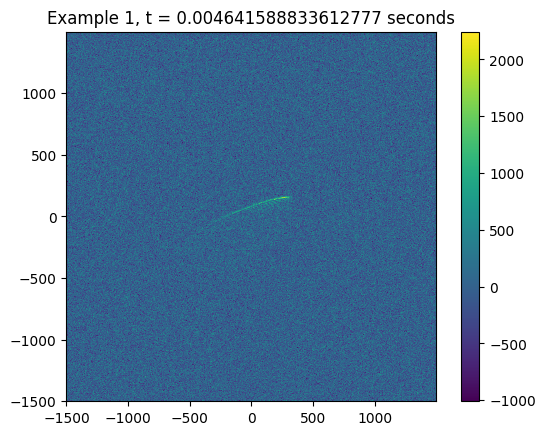

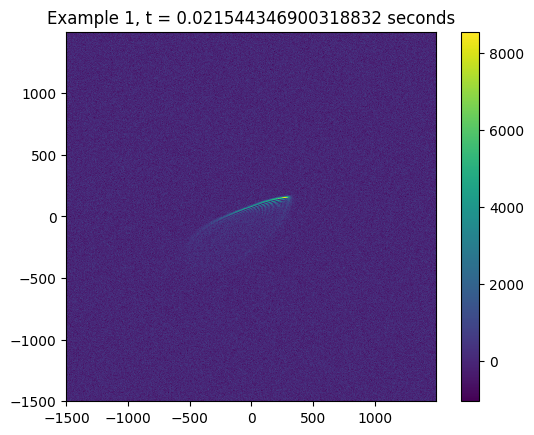

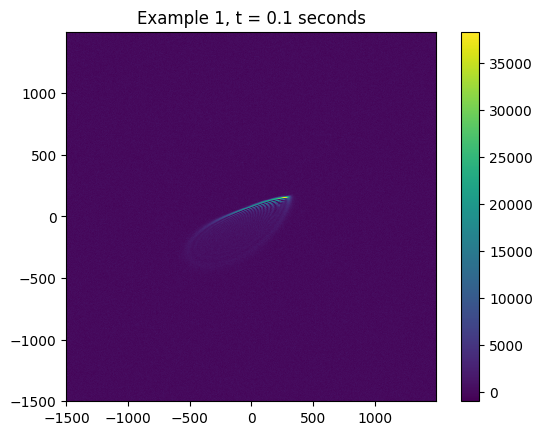

In [110]:
flatfield = 0 # 5% flat field error
darkcurrentrate = 200.99 # electrons per second
readnoise = 200.13 # rms electrons per read out
photonnoise = True

detector_example_1 = NoisyDetector(detector_grid=focal_grid, include_photon_noise=photonnoise, 
                                   flat_field=flatfield, dark_current_rate=darkcurrentrate, read_noise=readnoise)

integration_time = np.logspace(-3,-1,4)

for t in integration_time:

    #Science measurement.
    detector_example_1.integrate(focal_wavefront, t)
    measurement = detector_example_1.read_out()

    plt.figure()
    imshow_field(measurement)
    plt.colorbar()
    plt.title('Example 1, t = ' + str(t) + ' seconds')

plt.show()

In [266]:

from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
import time

from hcipy.atmosphere import *

d=0.6
r0 = 0.2 # 0.3
wavelength = 590e-9
L0 = 20  
velocity = 6.7 # m/s
stencil_length = 2
coeficients_flat = [0, 0, 0, 0, 0, 0, 0, 0] #flat wavefront.
seed = 11

# pupil_grid = make_pupil_grid(256, 1)
# focal_grid = make_focal_grid_from_pupil_grid(pupil_grid)
aperture = make_circular_aperture(d)(pupil_grid)

zern_flat = make_zernike_basis(8, d, pupil_grid, starting_mode=1, ansi=False, radial_cutoff=True, use_cache=True)
full_wf_flat = zern_flat.linear_combination(coeficients_flat)
pupil_wavefront_flat = Wavefront(np.exp(1j*((2*np.pi)/590e-9)*full_wf_flat)*aperture, wavelength=590e-9)
wf = pupil_wavefront_flat

mode_basis = make_zernike_basis(6, d, pupil_grid, 4)

# layers = []
# layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared_from_fried_parameter(r0, wavelength), L0, velocity, 0, stencil_length, seed=seed)
# layer2 = ModalAdaptiveOpticsLayer(layer, mode_basis, 1)
# layers.append(layer2)
# layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared_from_fried_parameter(r0, wavelength), L0, velocity, 0, stencil_length, seed=seed)
# layer3 = ModalAdaptiveOpticsLayer(layer, mode_basis, 1)
# layers.append(layer3)
# layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared_from_fried_parameter(r0, wavelength), L0, velocity, 0, stencil_length, seed=seed)
# layer4 = ModalAdaptiveOpticsLayer(layer, mode_basis, 1)
# layers.append(layer4)
layers = make_keck_atmospheric_layers(pupil_grid)
atmosphere = MultiLayerAtmosphere(layers, False)
# atmosphere.Cn_squared = Cn_squared_from_fried_parameter(1/40, wavelength) # for setting the Cn_squared of all the atmosphere layers
# prop = FraunhoferPropagator(pupil_grid, focal_grid.scaled(wavelength))




In [244]:
t = 0.001
atmosphere.evolve_until(t)

wf2 = atmosphere.forward(wf)
wf2.electric_field *= aperture

# plt.figure()
# imshow_field(wf2.phase, cmap='RdBu')
# plt.colorbar()
# plt.draw()

wf3 = wf2.copy()
wf3.electric_field = wf3.electric_field * pupil_wavefront.electric_field 

# plt.figure()
# imshow_field(wf3.phase, cmap='RdBu')
# plt.colorbar()
# plt.draw()

img = prop(wf3).intensity

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im1 = imshow_field(wf2.phase, cmap='RdBu', ax=axs[0])  # Ensure to pass the correct axis
plt.colorbar(im1, ax=axs[0], shrink=0.7)
im2 = imshow_field(wf3.phase, cmap='RdBu', ax=axs[1])  # Ensure to pass the correct axis
plt.colorbar(im2, ax=axs[1], shrink=0.7)
im3 = imshow_field(np.log10(img / img.max()), vmin=-2, ax=axs[2])  # Ensure to pass the correct axis
plt.colorbar(im3, ax=axs[2], shrink=0.7)
# fig.set_title(f'Phase at t={t:.1f} seconds')
fig.suptitle(f'Phase at t={t:.1f} seconds', y=0.85)  # Adjust the value of y to bring the title closer to the figures


plt.draw()  # Update the figure
plt.show()


<Figure size 1500x500 with 0 Axes>

In [269]:

def generate_frame(t, wf, aperture, atmosphere, pupil_wavefront):
    """Generate and save a frame for the given time t."""
    atmosphere.evolve_until(t)
    wf2 = atmosphere.forward(wf)
    wf3 = wf2.copy()
    wf3.electric_field = (wf2.electric_field * aperture) * pupil_wavefront.electric_field
    img = prop(wf3).intensity
    return wf2.phase, wf3.phase, img

# Parameters
num_frames = 100
frame_interval = 0.001  # Time interval between frames

# Path for saving frames
path_to_save = "frames/frame_{:03d}.png"
atmosphere.reset()
# Create a video writer instance
with get_writer('output_video_keck_layers.mp4', fps=20) as writer:
    for frame in tqdm(range(num_frames), desc='Generating Frames'):  # tqdm wrapper around the loop

        # fig, ax = plt.subplots()
        
        t = frame * frame_interval
        atmo_phase, system_phase, psf = generate_frame(t, wf, aperture, atmosphere, pupil_wavefront)
        fig.clear() 
        fig, axs = plt.subplots(1, 3,figsize=(15.04, 5.12))
        # Plotting the phase
        # ax.clear()
        

        im1 = imshow_field(atmo_phase, cmap='RdBu', ax=axs[0])  # Ensure to pass the correct axis
        plt.colorbar(im1, ax=axs[0], shrink=0.7)
        im2 = imshow_field(system_phase, cmap='RdBu', ax=axs[1])  # Ensure to pass the correct axis
        plt.colorbar(im2, ax=axs[1], shrink=0.7)
        im3 = imshow_field(np.log10(psf / psf.max()), vmin=-2, ax=axs[2])  # Ensure to pass the correct axis
        plt.colorbar(im3, ax=axs[2], shrink=0.7)
        fig.suptitle(f'Phase at t={t:.3f} seconds, Keck observatory', y=0.85)  # Adjust the value of y to bring the title closer to the figures
        plt.savefig(path_to_save.format(frame))
        plt.close(fig)

        # im = imshow_field(phase, cmap='RdBu')
        # plt.colorbar(im, ax=ax)
        # ax.set_title(f'Phase at t={t:.1f} seconds')
        
        # Save to file
        # plt.savefig(path_to_save.format(frame))
        # plt.close(fig)
        
        # Add frame to video
        writer.append_data(plt.imread(path_to_save.format(frame)))

# Optionally, delete frames (this part can be handled in Python using os.remove)

Generating Frames: 100%|██████████| 100/100 [10:03<00:00,  6.04s/it]
